# Creating Tables and Presenting Treatment Effects

In this workbook, I estimate models and treatment effects by hand. I also mock up a few figures and some tables depicting results. 

In [ ]:
import ipystata
import os

cd = os.getcwd()
cdl = [cd]

In [ ]:
%%stata -s gl -i cdl
chdir "`cdl'"

clear all 
set more off 

use "`cdl'\DataFiles\WorkingData.dta"

# Surgical Decision Model

The first model was simply whether or not surgery was applied. The model was fit using a doubly-robust estimator, which is the augmented inverse probability weighted estimator. After having reduced the number of variables under consideration [in this workbook](Lassoing Treatment and Outcome Models.ipynb), we follow the recipe in [Wooldridge, Chapter 21, pp. 930-931](https://mitpress.mit.edu/books/econometric-analysis-cross-section-and-panel-data). One proceeds as follows:

1. Fit a parametric model of treatment (like a logit or a probit) to get a propensity score.
2. Form probability weights using the propensity scores, and then.
3. Fit weighted outcome models for the treatment group and the non-treatment group. 
4. Use the outcome models to predict treatment outcomes ($y_{i1}$) and non-treatment outcomes ($y_{i0}$) for all $i \in N$ observations. Then:
5. Estimate treatment effects using the average across the sample:

$$
ATE = \frac{1}{N}\sum_{i=1}^N (y_{i1}-y_{i0})
$$

This is an implementation of a doubly-robust estimator. The lasso applied [as described here](Lassoing Treatment and Outcome Models.ipynb)) picked out the following variables as meaningful predictors of the surgical decision, and outcomes both with and without surgery:

|Variable | Description |
|---------|-------------|
|`sev`        | Wound severity scale based on description   |
|`longname`   | Presence of a middle initial (very rough status proxy) |
|`lncas`      | (Log of) regimental casualties (proxy for triage) |
|`td1`        | Wound location == arm |
|`td5`        | Wound location == hand |
|`td6`        | Wound location == head |
|`td8`        | Wound location == knee |
|`Mo29`       | Member of 29th Missouri |
|`In49`       | Member of 49th Indiana  |
|`Oh16`       | Member of 16th Ohio     |
|`Mo06`       | Member of 6th Missouri  |

In [3]:
%%stata -s gl -os

label var operated "Procedure"
logit operated sev longname lncas td1 td5 td6 td8 td9 td10 Mo29 Mo06, vce(robust)

mat et = e(b)
mat Vt = e(V)
scalar Nt = e(N)

predict ps, p

gen w = 1/ps*operated + 1/(1-ps)*(1-operated)

label var outcome "Outcome: Procedure"
logit outcome sev td1 td5 td8 td10 Il13 [pweight=w] if operated == 1, vce(robust)
predict y1, p

mat e1 = e(b)
mat V1 = e(V)
scalar N1 = e(N)

gen outcome2 = outcome
label var outcome2 "Outcome: No Procedure"
logit outcome2 sev td1 td5 td8 td10 Il13 [pweight=w] if operated == 0, vce(robust)
predict y0, p

mat e0 = e(b)
mat V0 = e(V)
scalar N0 = e(N)

mat e = e1, e0, et
mat V = vecdiag(V1), vecdiag(V0), vecdiag(Vt)
mat V = diag(V)

erepost b=e V=V
estadd scalar N1 
estadd scalar N0
estadd scalar Nt
esttab using TablesFigures\sete.tex, coeflabels(td1 "Arm Wound" td5 "Hand Wound" td6 "Head Wound" td8 "Knee Wound" ///
     td9 "Leg Wound" td10 "Neck, Trunk, Shoulder Wound" Mo29 "29th Missouri" In49 "49th Indiana" severity "Severity" ///
     Mo06 "6th Missouri") label scalars("N1 N: Surgery" "N0 N: No surgery " "Nt N: Total") noobs wide nomtitles replace

drop outcome2


Iteration 0:   log pseudolikelihood = -303.87074  
Iteration 1:   log pseudolikelihood = -230.61562  
Iteration 2:   log pseudolikelihood = -227.19473  
Iteration 3:   log pseudolikelihood = -227.14294  
Iteration 4:   log pseudolikelihood = -227.14281  
Iteration 5:   log pseudolikelihood = -227.14281  

Logistic regression                             Number of obs     =        498
                                                Wald chi2(11)     =     100.88
                                                Prob > chi2       =     0.0000
Log pseudolikelihood = -227.14281               Pseudo R2         =     0.2525

------------------------------------------------------------------------------
             |               Robust
    operated |      Coef.   Std. Err.      z    P>|z|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
         sev |   4.816116   .6492358     7.42   0.000     3.543637    6.088595
    longname |  -.36313

# Average Treatment Effects

I now find average treatment effects, which amounts to computing the means of the predictions $y_1$ and $y_0$. I actually use the weighted mean, as this seems to make more sense to me as a reflection of the actual effect. In any event, the results are comparable. 

In [4]:
%%stata -s gl -os

gen teffect = y1 - y0

quietly mean y0 [pweight=w]
mat m = e(b)
scalar pom = m[1,1]
disp "Potential outcome mean is: " pom

quietly mean teffect [pweight=w]
mat m = e(b)
scalar mate = m[1,1]
disp "ATE is:                    " mate

quietly mean teffect if operated == 1 [pweight=w]
mat m = e(b)
scalar matet = m[1,1]
disp "ATET is:                   " matet

quietly mean teffect if operated == 0 [pweight=w]
mat m = e(b)
scalar matut = m[1,1]
disp "ATUT is:                   " matut


Potential outcome mean is: .74833348

ATE is:                    .1269098

ATET is:                   .13126866

ATUT is:                   .12320554



# Standard errors

I calculate the standard errors by the delta method following [Dowd, Greene, and Norton (2013)](http://onlinelibrary.wiley.com/doi/10.1111/1475-6773.12122/abstract). The formula they give is the following. What one essentially does is use the formula for a linear-quadratic form, where the derivative of the function with respect to the coefficients is used. I use a weighted average, actually, of the linear form. So, in the end, we have:

$$
se = \sqrt{\overline{\frac{\partial g(x_i\beta)}{\partial \beta}}\Sigma\overline{\frac{\partial g(x_i\beta)}{\partial \beta}}'}
$$

where 

$$
\overline{\frac{\partial g(x_i\beta)}{\partial \beta}}=\sum_{i=1}^Nw_i\frac{\partial g(x_i\beta)}{\partial \beta}
$$

and $\Sigma$ is the estimated variance matrix for the $\beta$'s.

In [5]:
%%stata -s gl -os

global outcomevars sev td1 td5 td6 td10

quietly logit outcome $outcomevars [pweight=w] if operated == 1

mat Sig1 = e(V)
predict xb1, xb

gen db1 = exp(xb1)/(1 + exp(xb1))^2

global v1s
foreach v of global outcomevars {
    gen db1_`v' = db1*`v'
    global v1s $v1s db1_`v'
}

global v1s $v1s db1


quietly logit outcome $outcomevars [pweight=w] if operated == 0 

mat Sig0 = e(V)
predict xb0, xb

gen db0 = exp(xb0)/(1 + exp(xb0))^2

global v0s
foreach v of global outcomevars {
    gen db0_`v' = db0*`v'
    global v0s $v0s db0_`v'
}

global v0s $v0s db0


mata:
    st_view(dg1=., ., "$v1s")
    st_view(dg0=., ., "$v0s")
    S1 = st_matrix("Sig1")
    S0 = st_matrix("Sig0")
    st_view(treat=., ., "operated")
    st_view(w=.,.,"w")
end	

mata:
    dg = dg1, dg0
    
    S=blockdiag(S1, S0)

    dgm = mean(dg, w)
    se = sqrt(dgm*S*dgm')
    st_numscalar("stderr_ate", se)
    
    dgm = mean(dg[mm_which(treat), ], w[mm_which(treat),])          
    se_t = sqrt(dgm*S*dgm')
    st_numscalar("stderr_atet", se_t)
                
    dgm = mean(dg[mm_which(1 :- treat),], w[mm_which(1 :- treat),] )
    set_nt = sqrt(dgm*S*dgm')
    st_numscalar("stderr_atnt", set_nt)
                  
    dgm=mean(dg0, w)
    se_pom = sqrt(dgm*S0*dgm')
    st_numscalar("stderr_pom", se_pom)
                  
    
end

display "Standard Error of the POM is:  " stderr_pom
display "Standard Error of the ATE is:  " stderr_ate
display "Standard Error of the ATET is: " stderr_atet
display "Standard Error of the ATNT is: " stderr_atnt
              
drop xb0 xb1 db0 db1 $v1s $v0s


Standard Error of the POM is:  .02518648

Standard Error of the ATE is:  .0366923

Standard Error of the ATET is: .03760078

Standard Error of the ATNT is: .03612329



# Table of treatment effects

I will just tabulate and write these effects to a little table. Here goes:

In [6]:
%%writefile "TablesFigures\teffects1.tex"
\def\sym#1{\ifmmode^{#1}\else\(^{#1}\)\fi}
\begin{tabular}{lcc} \hline \hline
                                  &  Estimate & Standard Error      \\ \hline
Potential outcome mean            & 0.748\sym{***}     & 0.025      \\
Average treatment effect          & 0.127\sym{***}     & 0.036      \\
Average treatment effect, treated & 0.131\sym{***}     & 0.036      \\ \hline
\multicolumn{3}{l}{\footnotesize \sym{*} \(p<0.05\), \sym{**} \(p<0.01\), \sym{***} \(p<0.001\)}\\
\hline \hline
\end{tabular}

Overwriting TablesFigures\teffects1.tex


# Overlap graph

Creating an overlap graph is just a matter of breaking down the treatment effects. 


0
(69 real changes made)
(118 real changes made)
(56 real changes made)
(41 real changes made)
(39 real changes made)
(30 real changes made)
(18 real changes made)
(24 real changes made)
(16 real changes made)
(22 real changes made)
(21 real changes made)
(20 real changes made)
(15 real changes made)
(5 real changes made)
1
(4 real changes made)

(15 real changes made)

(15 real changes made)

(file TablesFigures/support.eps written in EPS format)



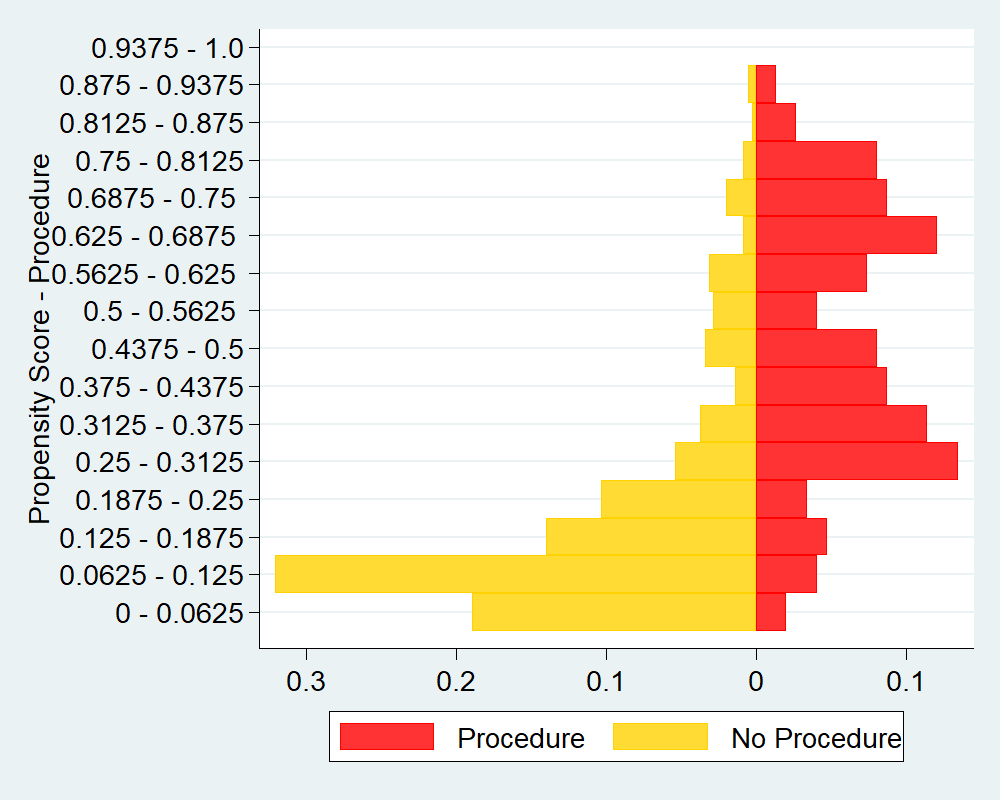

In [7]:
%%stata -s gl -gr -os

gen bin = 0
local bins = 15
forvalues i = 1/`bins' {
    disp `i'/`bins'
    disp (`i'-1)/`bins'
    replace bin = `i' if ps <= `i'/`bins' & ps > (`i'-1)/`bins'
}

gen didnotoperate = 1-operated

preserve
collapse (sum) operated didnotoperate, by (bin)

egen sumop = total(operated)
egen sumno = total(didnotoperate)

replace didnotoperate = - didnotoperate/sumno
replace operated = operated/sumop

twoway bar operated bin, horizontal color(red) || bar didnotoperate      ///
    bin, horizontal xlabel(-.3 "0.3" -.2 "0.2" -.1 "0.1" 0 "0" .1 "0.1") ///
    color(gold  ) legend(label(1 Procedure) label(2 No Procedure))       ///
    ylabel( 1 "0 - 0.0625" 2 "0.0625 - 0.125" 3 "0.125 - 0.1875"         ///
    4 "0.1875 - 0.25" 5 "0.25 - 0.3125" 6 "0.3125 - 0.375"               ///
    7 "0.375 - 0.4375" 8 "0.4375 - 0.5"  9 "0.5 - 0.5625 "               ///
    10 "0.5625 - 0.625 " 11 "0.625 - 0.6875 "                            ///
    12 "0.6875 - 0.75 " 13 "0.75 - 0.8125" 14 "0.8125 - 0.875"           ///
    15 " 0.875 - 0.9375" 16 "0.9375 - 1.0", angle(horizontal))           ///
    ytitle("Propensity Score - Procedure") 
graph export TablesFigures/support.eps, replace
restore 

# Graphing the surgical decision and outcomes



(file TablesFigures/teffects.eps written in EPS format)



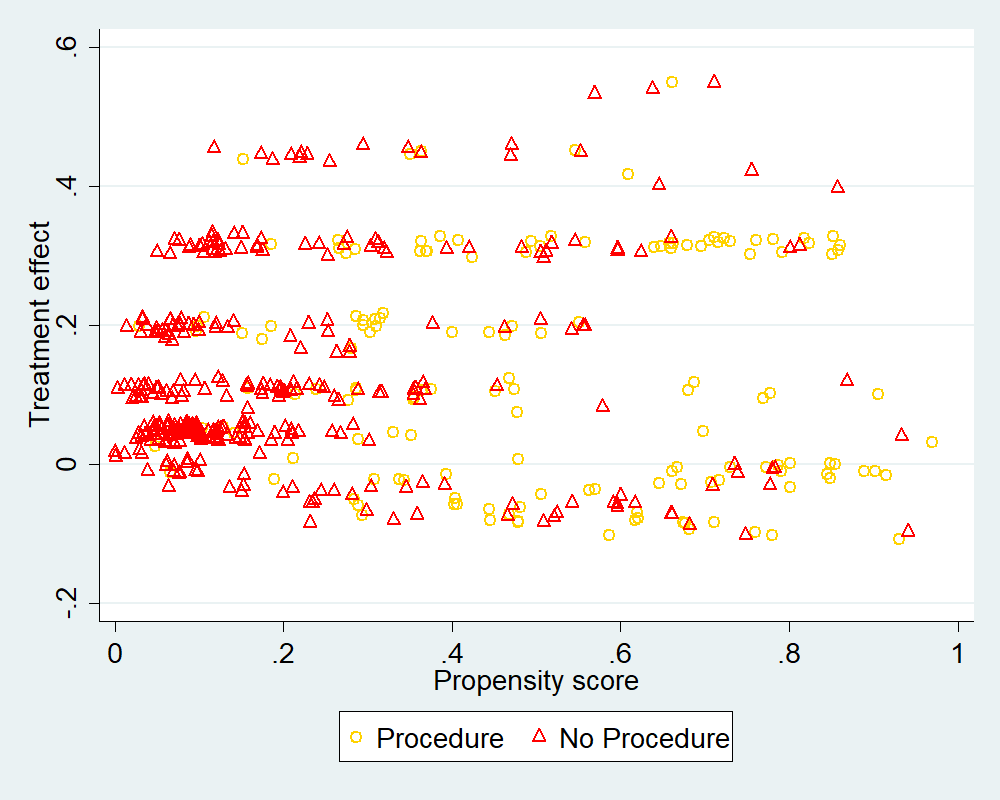

In [8]:
%%stata -s gl -gr -os
twoway (scatter teffect ps  if operated == 1, jitter(3) mcolor(gold)   ///
    msymbol(circle_hollow) mfcolor(none) msize(medium) )               ///
    (scatter teffect ps  if operated == 0, jitter(3) mcolor(red)       ///
    msymbol(triangle_hollow) msize(medium)),                           ///
    legend(label(1 "Procedure") label(2 "No Procedure"))               /// 
    ytitle(Treatment effect)                                           ///
    xtitle(Propensity score) 
graph export TablesFigures/teffects.eps, replace

# Expanded Model One - Multiple Treatments

We also fit a model with multiple treatments, where we have excision/resection, amputation, and no treatment as the many-valued treatment. The very first thing we have to do is get rid of the observations that it turns out don't split across treatments - these are, basically, head wounds, which are marked by the dummy `td6`; wounds of the neck, trunk, and shoulder `td10`, and hip wounds `td7`. These wounds are never treated with amputation, and hence violate the overlap assumption.

In [9]:
%%stata -s gl -os

preserve
drop if td6 | td10 | td7


(163 observations deleted)



The resulting treatment model we got after running the lasso was as follows:

In [10]:
%%stata -s gl -os

label var expoper "Procedure type"
label define surgtype 0 "None" 1 "Amputation" 2 "Intricate"

label values expoper surgtype

mlogit expoper sev longname lncas td5 td8 td9, vce(robust)
mat et = e(b)
mat et = et[1, 8..21]
mat Vt = e(V)
mat Vt = Vt[8..21, 8..21]
scalar Nt = e(N)

predict p0 p1 p2, p

gen w3 = 1/p0*(expoper == 0) + 1/p1*(expoper == 1) + 1/p2*(expoper == 2)

label var outcome "Outcome: No Procedure"
logit outcome sev [pweight=w3] if expoper == 0

mat e0 = e(b)
mat V0 = e(V)
scalar N0 = e(N)

predict y30, p


gen outcome2 = outcome
label var outcome2 "Outcome: Amputation"
logit outcome2 sev [pweight=w3] if expoper == 1

mat e1 = e(b)
mat V1 = e(V)
scalar N1 = e(N)

predict y31, p

gen outcome3 = outcome
label var outcome3 "Outcome: Intricate"
logit outcome3 sev [pweight=w3] if expoper == 2

mat e2 = e(b)
mat V2 = e(V)
scalar N2 = e(N)

predict y32, p

mat e = e0, e1, e2, et
mat V = vecdiag(V0), vecdiag(V1), vecdiag(V2), vecdiag(Vt)
mat V = diag(V)

erepost b=e V=V
estadd scalar N2
estadd scalar N1 
estadd scalar N0
estadd scalar Nt

esttab using TablesFigures\sete2.tex, coeflabels(td5 "Hand Wound" td8 "Knee Wound" td9 "Leg Wound")         ///
    scalars("N2 N: Intricate" "N1 N: Amputation" "N0 N: No Procedure " "Nt N: Total")        ///
    noobs wide nomtitles replace label
    
gen teffect1 = y31 - y30
gen teffect2 = y32 - y30


Iteration 0:   log pseudolikelihood =  -295.9093  
Iteration 1:   log pseudolikelihood = -224.41593  
Iteration 2:   log pseudolikelihood = -218.65211  
Iteration 3:   log pseudolikelihood = -218.56947  
Iteration 4:   log pseudolikelihood = -218.56934  
Iteration 5:   log pseudolikelihood = -218.56934  

Multinomial logistic regression                 Number of obs     =        335
                                                Wald chi2(12)     =     121.04
                                                Prob > chi2       =     0.0000
Log pseudolikelihood = -218.56934               Pseudo R2         =     0.2614

------------------------------------------------------------------------------
             |               Robust
     expoper |      Coef.   Std. Err.      z    P>|z|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
None         |  (base outcome)
-------------+---------------------------------------------------------

In [11]:
%%stata -s gl -os

global outcomevars sev 

quietly logit outcome $outcomevars [pweight=w3] if expoper == 0

mat Sig0 = e(V)
predict xb0, xb

gen db0 = exp(xb0)/(1 + exp(xb0))^2

global v0s
foreach v of global outcomevars {
    gen db0_`v' = db0*`v'
    global v0s $v0s db0_`v'
}

global v0s $v0s db0

quietly logit outcome $outcomevars [pweight=w3] if expoper == 1 

mat Sig1 = e(V)
predict xb1, xb

gen db1 = exp(xb1)/(1 + exp(xb1))^2

global v1s
foreach v of global outcomevars {
    gen db1_`v' = db1*`v'
    global v1s $v1s db1_`v'
}

global v1s $v1s db1

quietly logit outcome $outcomevars [pweight=w3] if expoper == 2

mat Sig2 = e(V)
predict xb2, xb

gen db2 = exp(xb2)/(1 + exp(xb2))^2

global v2s
foreach v of global outcomevars {
    gen db2_`v' = db2*`v'
    global v2s $v2s db2_`v'
}

global v2s $v2s db2

mata:
    st_view(dg0=., ., "$v0s")
    st_view(dg1=., ., "$v1s")
    st_view(dg2=., ., "$v2s")
    S0 = st_matrix("Sig0")
    S1 = st_matrix("Sig1")
    S2 = st_matrix("Sig2")
    st_view(treat=., ., "expoper")
    st_view(w=.,.,"w3")
end	

mata:
    dg1 = dg0, dg1
    dg2 = dg0, dg2
    
    S1=blockdiag(S0, S1)
    S2=blockdiag(S0, S2)

    dgm1 = mean(dg1, w)
    se1 = sqrt(dgm1*S1*dgm1')
    st_numscalar("stderr_ate1", se1)
    
    dgm1 = mean(dg1[mm_which(treat :== 1), ], w[mm_which(treat :== 1), ])          
    se_t1 = sqrt(dgm1*S1*dgm1')
    st_numscalar("stderr_atet1", se_t1)
                
    dgm1 = mean(dg1[mm_which(treat :== 0 ), ], w[mm_which(treat :== 0), ])
    set_nt1 = sqrt(dgm1*S1*dgm1')
    st_numscalar("stderr_atnt1", set_nt1)
    
    dgm2 = mean(dg2)
    se2 = sqrt(dgm2*S2*dgm2')
    st_numscalar("stderr_ate2", se2)

    dgm2 = mean(dg2[mm_which(treat :== 2), ], w[mm_which(treat :== 2), ])          
    se_t2 = sqrt(dgm2*S2*dgm2')
    st_numscalar("stderr_atet2", se_t)
                
    dgm2 = mean(dg2[mm_which(treat :== 0 ), ], w[mm_which(treat :== 0), ])
    set_nt2 = sqrt(dgm2*S2*dgm2')
    st_numscalar("stderr_atnt2", set_nt2) 
                   
    dgm = mean(dg0, w)
    se_pom = sqrt(dgm*S0*dgm')
    st_numscalar("se_pom", se_pom)
end

display "Standard Error of the ATE for amp. is:  " stderr_ate1
display "Standard Error of the ATET for amp. is: " stderr_atet1
display "Standard Error of the ATNT for not amp. is: " stderr_atnt1

display "Standard Error of the ATE for int. is:  " stderr_ate2
display "Standard Error of the ATET for int. is: " stderr_atet2
display "Standard Error of the ATNT for not int. is: " stderr_atnt2
                  
display "Standard Error for the POM is: " se_pom               


Standard Error of the ATE for amp. is:  .06018122

Standard Error of the ATET for amp. is: .06616565

Standard Error of the ATNT for not amp. is: .05754635

Standard Error of the ATE for int. is:  .05081004

Standard Error of the ATET for int. is: .03760078

Standard Error of the ATNT for not int. is: .05928762

Standard Error for the POM is: .04189107



In [12]:
%%stata -s gl -os

quietly mean y30 [pweight=w3]
mat m = e(b)
scalar pom = m[1,1]
disp "Potential outcome mean is: " pom

quietly mean teffect1 [pweight=w3]
mat m = e(b)
scalar mate1 = m[1,1]
disp "ATE1 is:                    " mate1

quietly mean teffect1 if expoper == 1 [pweight=w3]
mat m = e(b)
scalar matet1 = m[1,1]
disp "ATET1 is:                   " matet1

quietly mean teffect2 [pweight=w3]
mat m = e(b)
scalar mate2 = m[1,1]
disp "ATE2 is                     " mate2 

quietly mean teffect2 if expoper == 2 [pweight=w3]
mat m = e(b)
scalar matet2 = m[1,1]
disp "ATET2 is:                   " matet2

restore


Potential outcome mean is: .78840165

ATE1 is:                    .03790466

ATET1 is:                   .04280325

ATE2 is                     .11030237

ATET2 is:                   .10924636



# Expanded model Two - Injuries in critical locations

Here, we drop all the wounds of extremities and focus on wounds in critical locations. Intuitively, these wounds require a more involved treatment. Typically, an amputation, even, would require that some additional surgical work be done - tying of arteries/veins, etc. 

In [13]:
%%stata -s gl

preserve
keep if td6 | td7 | td8 | td9 | td10 | td11

capture drop ps
capture drop w
capture drop outcome2
capture drop y1 y0

logit operated sev lncas td6 td8 In49, vce(robust)

mat et = e(b)
mat Vt = e(V)
scalar Nt = e(N)

predict ps, p

gen w = 1/ps*operated + 1/(1-ps)*(1-operated)

logit outcome sev lncas td8 td9 td10 [pweight=w] if operated == 1, vce(robust)
predict y1, p

mat e1 = e(b)
mat V1 = e(V)
scalar N1 = e(N)

gen outcome2 = outcome
label var outcome2 "Outcome: No Procedure"
logit outcome2 sev lncas td8 td9 td10 [pweight=w] if operated == 0, vce(robust)
predict y0, p

mat e0 = e(b)
mat V0 = e(V)
scalar N0 = e(N)

mat e = e1, e0, et
mat V = vecdiag(V1), vecdiag(V0), vecdiag(Vt)
mat V = diag(V)

erepost b=e V=V
estadd scalar N1 
estadd scalar N0
estadd scalar Nt
esttab using TablesFigures\sete3.tex, coeflabels(td8 "Knee Wound" td9 "Leg Wound" td10 "Neck, Trunk, Shoulder Wound" ///
      In49 "49th Indiana") label scalars("N1 N: Surgery" "N0 N: No surgery " "Nt N: Total") noobs wide nomtitles replace


(171 observations deleted)

Iteration 0:   log pseudolikelihood = -176.08924  
Iteration 1:   log pseudolikelihood =  -140.0948  
Iteration 2:   log pseudolikelihood = -137.54747  
Iteration 3:   log pseudolikelihood = -137.50961  
Iteration 4:   log pseudolikelihood =  -137.5095  
Iteration 5:   log pseudolikelihood =  -137.5095  

Logistic regression                             Number of obs     =        327
                                                Wald chi2(5)      =      56.52
                                                Prob > chi2       =     0.0000
Log pseudolikelihood =  -137.5095               Pseudo R2         =     0.2191

------------------------------------------------------------------------------
             |               Robust
    operated |      Coef.   Std. Err.      z    P>|z|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
         sev |   4.524944   .8696679     5.20   0.000     2.820426    6.22

In [14]:
%%stata -s gl -os

gen teffect = y1 - y0

quietly mean y0 [pweight=w]
mat m = e(b)
scalar pom = m[1,1]
disp "Potential outcome mean is: " pom

quietly mean teffect [pweight=w]
mat m = e(b)
scalar mate = m[1,1]
disp "ATE is:                    " mate

quietly mean teffect if operated == 1 [pweight=w]
mat m = e(b)
scalar matet = m[1,1]
disp "ATET is:                   " matet

quietly mean teffect if operated == 0 [pweight=w]
mat m = e(b)
scalar matut = m[1,1]
disp "ATUT is:                   " matut

variable teffect already defined
r(110);

Potential outcome mean is: .6606227

ATE is:                    .1732283

ATET is:                   .17198122

ATUT is:                   .17435033



In [15]:
%%stata -s gl -os

global outcomevars sev lncas td8 td9 td10

quietly logit outcome $outcomevars [pweight=w] if operated == 1

mat Sig1 = e(V)
predict xb1, xb

gen db1 = exp(xb1)/(1 + exp(xb1))^2

global v1s
foreach v of global outcomevars {
    gen db1_`v' = db1*`v'
    global v1s $v1s db1_`v'
}

global v1s $v1s db1


quietly logit outcome $outcomevars [pweight=w] if operated == 0 

mat Sig0 = e(V)
predict xb0, xb

gen db0 = exp(xb0)/(1 + exp(xb0))^2

global v0s
foreach v of global outcomevars {
    gen db0_`v' = db0*`v'
    global v0s $v0s db0_`v'
}

global v0s $v0s db0


mata:
    st_view(dg1=., ., "$v1s")
    st_view(dg0=., ., "$v0s")
    S1 = st_matrix("Sig1")
    S0 = st_matrix("Sig0")
    st_view(treat=., ., "operated")
    st_view(w=.,.,"w")
end	

mata:
    dg = dg1, dg0
    
    S=blockdiag(S1, S0)

    dgm = mean(dg, w)
    se = sqrt(dgm*S*dgm')
    st_numscalar("stderr_ate", se)
    
    dgm = mean(dg[mm_which(treat), ], w[mm_which(treat),])          
    se_t = sqrt(dgm*S*dgm')
    st_numscalar("stderr_atet", se_t)
                
    dgm = mean(dg[mm_which(1 :- treat),], w[mm_which(1 :- treat),] )
    set_nt = sqrt(dgm*S*dgm')
    st_numscalar("stderr_atnt", set_nt)
                  
    dgm=mean(dg0, w)
    se_pom = sqrt(dgm*S0*dgm')
    st_numscalar("stderr_pom", se_pom)
                  
    
end

display "Standard Error of the POM is:  " stderr_pom
display "Standard Error of the ATE is:  " stderr_ate
display "Standard Error of the ATET is: " stderr_atet
display "Standard Error of the ATNT is: " stderr_atnt
              
drop xb0 xb1 db0 db1 $v1s $v0s


Standard Error of the POM is:  .03036709

Standard Error of the ATE is:  .04305373

Standard Error of the ATET is: .04570799

Standard Error of the ATNT is: .04089097



In [16]:
%%writefile "TablesFigures\teffects2.tex"
\def\sym#1{\ifmmode^{#1}\else\(^{#1}\)\fi}
\begin{tabular}{lcc} \hline \hline
                                  \multicolumn{3}{c}{\textbf{Multiple Treatments (N=349)}} \\
                                  &  Estimate & Standard Error      \\ \hline                                  
Potential outcome mean            & 0.791\sym{***}     & 0.042      \\
\multicolumn{3}{l}{\textbf{Amputation}}                             \\
Average treatment effect          & 0.037              & 0.060      \\
Average treatment effect, treated & 0.043              & 0.066      \\
\multicolumn{3}{l}{\textbf{Intricate}}                              \\
Average treatment effect          & 0.110\sym{**}     & 0.051       \\
Average treatment effect, treated & 0.109\sym{***}    & 0.038       \\ \hline \hline
                                  \multicolumn{3}{c}{\textbf{Critical Wound Locations (N=327)}} \\ 
                                  & Estimate & Standard Error       \\ \hline
Potential outcome mean            & 0.661\sym{***}     & 0.030      \\
Average treatment effect          & 0.173\sym{***}     & 0.043      \\
Average treatment effect, treated & 0.172\sym{***}     & 0.046      \\ \hline                            
\multicolumn{3}{l}{\footnotesize \sym{*} \(p<0.05\), \sym{**} \(p<0.01\), \sym{***} \(p<0.001\)}\\
\hline \hline
\end{tabular}

Overwriting TablesFigures\teffects2.tex
